In [1]:
import torch
from torch import nn, Tensor
from torch.distributions import Uniform
from einops import rearrange
import matplotlib.pyplot as plt
import numpy as np

from smcdet.images import M71ImageModel
from smcdet.distributions import TruncatedPareto

import pickle

from utils.misc import select_cuda_device

device = select_cuda_device()
torch.cuda.set_device(device)
torch.set_default_device(device)

Selected device 0, which has 10822 MB available.


Define prior and image model:

In [2]:
with open('../experiments/m71/data/params.pkl', 'rb') as f:
    params = pickle.load(f)

In [3]:
image_dim = 16
pad = 2

loc_prior = Uniform(
    (0 - pad) * torch.ones(2),
    torch.tensor((image_dim + pad, image_dim + pad))
)
flux_prior = TruncatedPareto(
    alpha = params["flux_alpha"],
    lower = params["flux_detection_threshold"],
    upper = params["flux_upper"]
)

In [4]:
imagemodel = M71ImageModel(
    image_height = image_dim,
    image_width = image_dim,
    background = params["background"],
    adu_per_nmgy = params["adu_per_nmgy"],
    psf_params = params["psf_params"],
    psf_radius = params["psf_radius"],
    noise_additive = params["noise_additive"],
    noise_multiplicative = params["noise_multiplicative"]
)

Sample 2000 catalogs and images. Each catalog has two stars, each parametrized by a flux (in nmgy) and a 2D location:

In [5]:
num_images = 2000
num_stars_per_image = 4

locs = loc_prior.sample([num_images, num_stars_per_image])
logfluxes = flux_prior.sample([num_images, num_stars_per_image, 1]).log()

catalogs = torch.cat((locs, logfluxes), dim=-1)

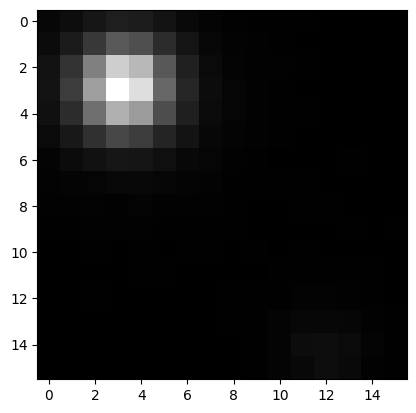

In [6]:
images = imagemodel.sample(rearrange(locs, "n d t -> 1 1 n d t"),
                           rearrange(logfluxes.exp(), "n d 1 -> 1 1 n d"))
images = rearrange(images, "1 1 dimH dimW n -> n 1 dimH dimW")

idx = torch.randint(0, num_images, [])
_ = plt.imshow(images[idx].squeeze().cpu(), cmap = 'gray')

Define the flow:

In [7]:
class Flow(nn.Module):
    def __init__(self, catalog_dim: int, image_embed_dim: int):
        super().__init__()

        self.image_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(256, 256, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Flatten(),
            nn.Linear(256, image_embed_dim)
        )

        self.time_encoder = nn.Sequential(
            nn.Linear(1, catalog_dim // 2),
            nn.SiLU(),
            nn.Linear(catalog_dim // 2, catalog_dim)
        )

        self.velocity_net = nn.Sequential(
            nn.Linear(catalog_dim + image_embed_dim, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, catalog_dim)
        )
    
    def forward(self, z: Tensor, x: Tensor, t: Tensor) -> Tensor:
        x_encoded = self.image_encoder(x)
        t_encoded = self.time_encoder(t)
        return self.velocity_net(torch.cat((z + t_encoded, x_encoded), dim=-1))

    def step(self, z: Tensor, x: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        with torch.no_grad():
            t_start = t_start.view(1, 1).expand(z.shape[0], 1)
            z_mid = z + self(z, x, t_start) * (t_end - t_start) / 2
            v_mid = self(z_mid, x, t_start + (t_end - t_start) / 2)

            return z + (t_end - t_start) * v_mid

Train the flow:

In [8]:
flow = Flow(catalog_dim=catalogs.flatten(-2).shape[-1], image_embed_dim=128)
optimizer = torch.optim.Adam(flow.parameters(), lr = 1e-3)
loss = nn.MSELoss()

In [9]:
batch_size = 32

for step in range(20000):
    indices = torch.randint(low = 0, high = images.shape[0], size = [batch_size])
    x = images[indices]
    z1 = catalogs[indices].flatten(-2)

    z0_locs = loc_prior.sample([batch_size, num_stars_per_image])
    z0_logfluxes = flux_prior.sample([batch_size, num_stars_per_image, 1]).log()
    z0 = torch.cat((z0_locs, z0_logfluxes), dim=-1).flatten(-2)

    t = torch.rand(len(z1), 1)

    zt = (1 - t) * z0 + t * z1

    dzt = z1 - z0

    optimizer.zero_grad()

    pred = flow(zt, x, t)

    l = loss(pred, dzt)
    l.backward()

    if step % 500 == 0:
        print(step)
        print(l)
    
    optimizer.step()

0
tensor(46.8187, device='cuda:0', grad_fn=<MseLossBackward0>)
500
tensor(47.1448, device='cuda:0', grad_fn=<MseLossBackward0>)
1000
tensor(44.0255, device='cuda:0', grad_fn=<MseLossBackward0>)
1500
tensor(41.4666, device='cuda:0', grad_fn=<MseLossBackward0>)
2000
tensor(38.3820, device='cuda:0', grad_fn=<MseLossBackward0>)
2500
tensor(28.4815, device='cuda:0', grad_fn=<MseLossBackward0>)
3000
tensor(18.8830, device='cuda:0', grad_fn=<MseLossBackward0>)
3500
tensor(13.9201, device='cuda:0', grad_fn=<MseLossBackward0>)
4000
tensor(13.0593, device='cuda:0', grad_fn=<MseLossBackward0>)
4500
tensor(14.1200, device='cuda:0', grad_fn=<MseLossBackward0>)
5000
tensor(11.3970, device='cuda:0', grad_fn=<MseLossBackward0>)
5500
tensor(10.9766, device='cuda:0', grad_fn=<MseLossBackward0>)
6000
tensor(11.2407, device='cuda:0', grad_fn=<MseLossBackward0>)
6500
tensor(12.5495, device='cuda:0', grad_fn=<MseLossBackward0>)
7000
tensor(11.7245, device='cuda:0', grad_fn=<MseLossBackward0>)
7500
tensor(7.

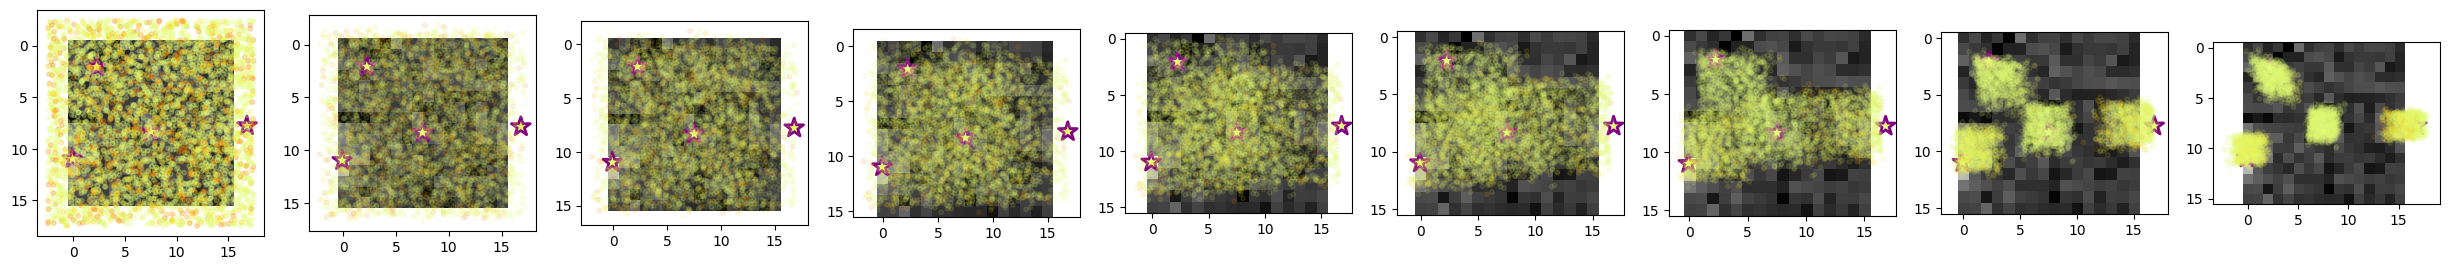

In [13]:
num_samples = 1000

z_locs = loc_prior.sample([num_samples, num_stars_per_image])
z_logfluxes = flux_prior.sample([num_samples, num_stars_per_image, 1]).log()
z = torch.cat((z_locs, z_logfluxes), dim=-1).flatten(-2)

image_index = torch.randint(0, images.shape[0], size = [])
x = images[image_index].unsqueeze(0).expand(num_samples, 1, image_dim, image_dim)

n_steps = 8
time_steps = torch.linspace(0.0, 1.0, n_steps + 1)

fig, ax = plt.subplots(1, n_steps + 1, figsize = (4*n_steps - 1, 3))
_ = ax[0].imshow(images[image_index].squeeze().cpu(), cmap = 'gray')
_ = ax[0].scatter(locs[image_index][:,1].cpu() - 0.5, locs[image_index][:,0].cpu() - 0.5,
                  c = logfluxes[image_index].exp().squeeze().cpu(), cmap = 'Wistia',
                  marker = '*', edgecolors = 'purple', linewidth = 2, s = 200,
                  vmin = z_logfluxes.exp().quantile(0.1), vmax = z_logfluxes.exp().quantile(0.9))
_ = ax[0].scatter(z_locs[:,:,1].cpu() - 0.5, z_locs[:,:,0].cpu() - 0.5,
                  c = z_logfluxes.exp().squeeze().cpu(), cmap = 'Wistia', s = 10, alpha = 0.25,
                  vmin = z_logfluxes.exp().quantile(0.1), vmax = z_logfluxes.exp().quantile(0.9))

for t in range(n_steps):
    z = flow.step(z, x, time_steps[t], time_steps[t+1])

    sampled_locs = z.detach().unflatten(-1, [num_stars_per_image, -1])[:,:,:2]
    sampled_fluxes = z.detach().unflatten(-1, [num_stars_per_image, -1])[:,:,2].exp()

    _ = ax[t+1].imshow(images[image_index].squeeze().cpu(), cmap = 'gray')
    _ = ax[t+1].scatter(locs[image_index][:,1].cpu() - 0.5, locs[image_index][:,0].cpu() - 0.5,
                        c = logfluxes[image_index].exp().squeeze().cpu(), cmap = 'Wistia',
                        marker = '*', edgecolors = 'purple', linewidth = 2, s = 200,
                        vmin = z_logfluxes.exp().quantile(0.1), vmax = z_logfluxes.exp().quantile(0.9))
    _ = ax[t+1].scatter(sampled_locs[:,:,1].cpu() - 0.5, sampled_locs[:,:,0].cpu() - 0.5,
                        c = sampled_fluxes.squeeze().cpu(), cmap = 'Wistia', s = 10, alpha = 0.1,
                        vmin = z_logfluxes.exp().quantile(0.1), vmax = z_logfluxes.exp().quantile(0.9))